# Λήψεις Τεσσάρων Πλευρών
Στο αρχείο multiple_views.yml έχουμε ορίσει από ποιες εικόνες ανιχνεύουμε επιφάνεια λιπώδους ιστού.

Δομή του αρχείου yaml: 
```
samples: [0h, 24h, 48h, 72h, 96h, 120h, 144h, 192h, 240h]
mouse_id: [mouse_1, mouse_2, mouse_3, mouse_4, mouse_5]
mouse_angle: [brosta, aristera, pisw, deksia]
mouse_1:
    brosta:
      csv: [CSV_2060.csv, CSV_2305.csv, CSV_2509.csv, CSV_2730.csv, CSV_2957.csv, CSV_3181.csv, CSV_3397.csv, CSV_3652.csv, CSV_3855.csv]
      jpg: [IR_2060.jpg, IR_2305.jpg, IR_2509.jpg, IR_2730.jpg, IR_2957.jpg, IR_3181.jpg, IR_3397.jpg, IR_3652.jpg, IR_3855.jpg]
    aristera: 
        jpg: [IR_2096.jpg, IR_2327.jpg, IR_2529.jpg, IR_2754.jpg, IR_2963.jpg, IR_3203.jpg, IR_3419.jpg, IR_3692.jpg, IR_3889.jpg]
        csv: [CSV_2096.csv, CSV_2327.csv, CSV_2529.csv, CSV_2754.csv, CSV_2963.csv, CSV_3203.csv, CSV_3419.csv, CSV_3692.csv, CSV_3889.csv]
    pisw:
      csv: [CSV_2088.csv, CSV_2321.csv, CSV_2517.csv, CSV_2740.csv, CSV_2977.csv, CSV_3197.csv, CSV_3431.csv, CSV_3682.csv, CSV_3863.csv]
      jpg: [IR_2088.jpg, IR_2321.jpg, IR_2517.jpg, IR_2740.jpg, IR_2977.jpg, IR_3197.jpg, IR_3431.jpg, IR_3682.jpg, IR_3863.jpg]
    deksia: 
        jpg: [IR_2080.jpg, IR_2333.jpg, IR_2523.jpg, IR_2748.jpg, IR_2961.jpg, IR_3209.jpg, IR_3417.jpg, IR_3698.jpg, IR_3883.jpg]
        csv: [CSV_2080.csv, CSV_2333.csv, CSV_2523.csv, CSV_2748.csv, CSV_2961.csv, CSV_3209.csv, CSV_3417.csv, CSV_3698.csv, CSV_3883.csv]
.
.
. κλπ
```
![εικόνα](img/cube_net.png)

In [1]:
import os
import sys
import yaml
import numpy as np
import pandas as pd
from tqdm import tqdm
import math

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
from celluloid import Camera
from IPython.display import HTML # to show the animation in Jupyter

from skimage.exposure import histogram
from skimage.filters.rank import entropy
from skimage.morphology import disk, square, skeletonize, thin, dilation
from skimage.util import img_as_ubyte
from skimage.feature import greycomatrix, greycoprops, local_binary_pattern
from skimage.measure import label, regionprops, regionprops_table

from sklearn import cluster
from sklearn import preprocessing
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from src.features import mouse_detection
from src.features import img_to_vectors
from src.data import data_utils
from src.visualization import rect_roi

# Εισαγωγή του αρχείου yaml
with open(module_path + '/data/multiple_views.yml') as file:
    experiment = yaml.load(file, Loader=yaml.FullLoader)
# access: experiment['samples'], experiment['mouse_id']

class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

src.data.data_utils


### Εισαγωγή Δεδομένων και Επεξεργασία

In [2]:
# Πρόσβαση στα δεδομένα του αρχείου
mouse_names = experiment['mouse_id'] 
mouse_angles = experiment['mouse_angle'] # ordering sides 
# Κατασκευή των global path για τα αρχεία του πειράματος
infrared_items = []
csv_items = []
for i, hour in enumerate(experiment['samples']):
    for mouse_name in mouse_names:
        for mouse_angle in mouse_angles:
            jpg_file = experiment[mouse_name][mouse_angle]['jpg'][i]
            full_jpg_path = f'{module_path}/data/raw/{hour}/{mouse_name}/{jpg_file}'
            infrared_items.append(full_jpg_path)
            
            csv_file = experiment[mouse_name][mouse_angle]['csv'][i]
            full_csv_path = f'{module_path}/data/raw/{hour}/{mouse_name}/{csv_file}'
            csv_items.append(full_csv_path)

# Εισαγωγή των δεδομένων με βάση τα path και προεπεξεργασία
infrared_images = []
for item in infrared_items:
    infrared_image, _ = data_utils.IR_fixer(fpath=item)
    infrared_images.append(infrared_image)

markerBack, markerBody = 70, 150
object_images, object_masks, initial_masks, mouse_locations = mouse_detection.mouse_detection(infrared_images, markerBack, markerBody)

### Πρόβλημα με Ελλειπή Δεδομένα csv
#### Αναντιστοιχία των Θερμικών Εικόνων με τα Δεδομένα του Αισθητήρα

In [ ]:
indicator_csv = pd.DataFrame(np.reshape(np.arange(45), (9, 5), order='F'), columns=experiment['mouse_id'], index=experiment['samples'])
indicator_jpg = pd.DataFrame(np.reshape(np.arange(45), (9, 5), order='F'), columns=experiment['mouse_id'], index=experiment['samples'])
name_csv = pd.DataFrame(np.reshape(np.arange(45), (9, 5), order='F'), columns=experiment['mouse_id'], index=experiment['samples'])
name_jpg = pd.DataFrame(np.reshape(np.arange(45), (9, 5), order='F'), columns=experiment['mouse_id'], index=experiment['samples'])
for i, hour in enumerate(experiment['samples']):
    for mouse_name in experiment['mouse_id']:
        counter_csv, counter_jpg = 0, 0
        indicators_csv, indicators_jpg = ['✔', '✔', '✔', '✔'], ['✔', '✔', '✔', '✔']
        names_csv, names_jpg = [], []
        for mouse_angle in experiment['mouse_angle']:
            jpg_file = experiment[mouse_name][mouse_angle]['jpg'][i]
            full_jpg_path = f'{module_path}/data/raw/{hour}/{mouse_name}/{jpg_file}'
            names_jpg.append(jpg_file)
            if not os.path.exists(full_jpg_path):
                indicators_jpg[counter_csv] = '❌'
                counter_jpg += 1
                
            csv_file = experiment[mouse_name][mouse_angle]['csv'][i]
            full_csv_path = f'{module_path}/data/raw/{hour}/{mouse_name}/{csv_file}'
            names_csv.append(csv_file)            
            if not os.path.exists(full_csv_path):
                indicators_csv[counter_csv] = '❌'
                counter_csv += 1
        indicator_csv.loc[hour, mouse_name] = f'{tuple(indicators_csv)}'
        indicator_jpg.loc[hour, mouse_name] = f'{tuple(indicators_jpg)}'
        name_csv.loc[hour, mouse_name] = f'{tuple(names_csv)}'
        name_jpg.loc[hour, mouse_name] = f'{tuple(names_jpg)}'        
display('indicator_csv', 'name_csv')

### Ενώ υπάρχουν 4 θερμικές λήψεις για κάθε δείγμα, δεν υπάρχουν όλα τα αρχεία θερμοκρασιών
#### Αυτό δεν είναι πρόβλημα για την τρισδιάστατη ανακατασκευή, καθώς θα χρησιμοποιηθούν μόνο οι jpg εικόνες

In [ ]:
csv_files = [] # will store (240, 160) arrays
for item in csv_items:
    csv_files.append(data_utils.CSV_fixer(item))
    
csv_thermals = [mask * csv for (mask, csv) in zip(initial_masks, csv_files)]
new_csv_thermals = [csv_thermal[mouse_location] for (csv_thermal, mouse_location) in zip(csv_thermals, mouse_locations)]

### Οι τέσσερεις πλευρές κάθε δείγματος

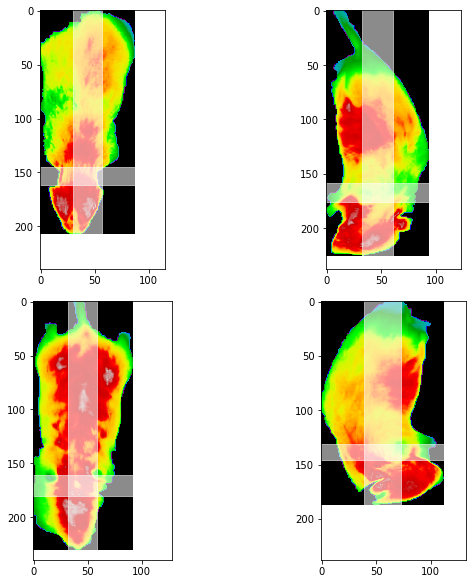

In [3]:
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
grid = fig.add_gridspec(nrows=2, ncols=2, wspace=0.2, hspace=0.25)
ax0 = fig.add_subplot(grid[0])
ax1 = fig.add_subplot(grid[1])
ax2 = fig.add_subplot(grid[2])
ax3 = fig.add_subplot(grid[3])
camera = Camera(fig)
for i in range(0, len(object_images), 4):
    ax0.imshow(X=object_images[i], cmap=plt.cm.nipy_spectral)
    xmin, xmax, ymin, ymax = rect_roi.rect_roi(object_images[i])
    ax0.axvspan(xmin=xmin, xmax=xmax, color='white', alpha=0.55)
    ax0.axhspan(ymin=ymin, ymax=ymax, color='white', alpha=0.55)

    ax1.imshow(X=object_images[i + 1], cmap=plt.cm.nipy_spectral)
    xmin, xmax, ymin, ymax = rect_roi.rect_roi(object_images[i + 1])
    ax1.axvspan(xmin=xmin, xmax=xmax, color='white', alpha=0.55)
    ax1.axhspan(ymin=ymin, ymax=ymax, color='white', alpha=0.55)
    
    ax2.imshow(X=object_images[i + 2], cmap=plt.cm.nipy_spectral)
    xmin, xmax, ymin, ymax = rect_roi.rect_roi(object_images[i + 2])
    ax2.axvspan(xmin=xmin, xmax=xmax, color='white', alpha=0.55)
    ax2.axhspan(ymin=ymin, ymax=ymax, color='white', alpha=0.55)
    
    ax3.imshow(X=object_images[i + 3], cmap=plt.cm.nipy_spectral)
    xmin, xmax, ymin, ymax = rect_roi.rect_roi(object_images[i + 3])
    ax3.axvspan(xmin=xmin, xmax=xmax, color='white', alpha=0.55)
    ax3.axhspan(ymin=ymin, ymax=ymax, color='white', alpha=0.55)
    camera.snap()
animation = camera.animate(interval=1000)
# το HTML πρέπει να τρέχει στο jupyter notebook 
recten = HTML(animation.to_html5_video()) # displaying the animation

### Διαστάσεις και Ιδιότητες Εικόνας

In [ ]:
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
grid = fig.add_gridspec(nrows=2, ncols=2, wspace=0.2, hspace=0.25)
ax0 = fig.add_subplot(grid[0])
ax1 = fig.add_subplot(grid[1])
ax2 = fig.add_subplot(grid[2])
ax3 = fig.add_subplot(grid[3])
camera = Camera(fig)
for i in range(0, len(object_images), 4):
    # img_to_vectors.img_to_vectors()
    regionprops_list = []
    
    regions = regionprops(object_masks[i].astype(np.uint8))
    regionprops_list.append(regions)
    
    ax0.imshow(object_masks[i], cmap=plt.cm.gray)
    for props in regions:
        y0, x0 = props.centroid
        orientation = props.orientation
        x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length
        y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
        x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
        y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length

        ax0.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
        ax0.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
        ax0.plot(x0, y0, '.g', markersize=15)

        minr, minc, maxr, maxc = props.bbox
        bx = (minc, maxc, maxc, minc, minc)
        by = (minr, minr, maxr, maxr, minr)
        ax0.plot(bx, by, '-b', linewidth=2.5)
        
    regions = regionprops(object_masks[i + 1].astype(np.uint8))
    regionprops_list.append(regions)
    
    ax1.imshow(object_masks[i + 1], cmap=plt.cm.gray)
    for props in regions:
        y0, x0 = props.centroid
        orientation = props.orientation
        x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length
        y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
        x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
        y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length

        ax1.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
        ax1.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
        ax1.plot(x0, y0, '.g', markersize=15)

        minr, minc, maxr, maxc = props.bbox
        bx = (minc, maxc, maxc, minc, minc)
        by = (minr, minr, maxr, maxr, minr)
        ax1.plot(bx, by, '-b', linewidth=2.5)
        
    regions = regionprops(object_masks[i + 2].astype(np.uint8))
    regionprops_list.append(regions)
    
    ax2.imshow(object_masks[i + 2], cmap=plt.cm.gray)
    for props in regions:
        y0, x0 = props.centroid
        orientation = props.orientation
        x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length
        y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
        x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
        y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length

        ax2.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
        ax2.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
        ax2.plot(x0, y0, '.g', markersize=15)

        minr, minc, maxr, maxc = props.bbox
        bx = (minc, maxc, maxc, minc, minc)
        by = (minr, minr, maxr, maxr, minr)
        ax2.plot(bx, by, '-b', linewidth=2.5)
        
    regions = regionprops(object_masks[i + 3].astype(np.uint8))
    regionprops_list.append(regions)
    
    ax3.imshow(object_masks[i + 3], cmap=plt.cm.gray)
    for props in regions:
        y0, x0 = props.centroid
        orientation = props.orientation
        x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length
        y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
        x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
        y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length

        ax3.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
        ax3.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
        ax3.plot(x0, y0, '.g', markersize=15)

        minr, minc, maxr, maxc = props.bbox
        bx = (minc, maxc, maxc, minc, minc)
        by = (minr, minr, maxr, maxr, minr)
        ax3.plot(bx, by, '-b', linewidth=2.5)
        
        camera.snap()
    jf = {}
animation = camera.animate(interval=1000)
# το HTML πρέπει να τρέχει στο jupyter notebook 
masken = HTML(animation.to_html5_video()) # displaying the animation

In [ ]:
len(regions)

In [ ]:
display('masken', 'recten')

In [ ]:
### feature: pad images centered to centroids
name_csv = pd.DataFrame(np.reshape(np.arange(45), (9, 5), order='F'), columns=experiment['mouse_id'], index=experiment['samples'])
name_jpg = pd.DataFrame(np.reshape(np.arange(45), (9, 5), order='F'), columns=experiment['mouse_id'], index=experiment['samples'])